### Hyper-Tuning Version 1 Code

`train_optuna.py` code

```python
import os
import time
import json
import pickle
import requests
import warnings
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import optuna
from optuna.trial import TrialState

import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split
from torchvision import datasets, transforms

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.filterwarnings('ignore')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# ----------------- Load Data -----------------------

class MyDataset(Dataset):
    def __init__(self, filename):
        with open(filename, "rb") as f:
            data = pickle.load(f)
        self._data = data

    def __getitem__(self, idx):
        return self._data[idx]

    def __len__(self):
        return len(self._data)

    
transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])


def stuff_data_cifar10():
    all_train = datasets.CIFAR10(root='./CIFAR_10', train=True, download=False, transform=transform)
    testset = datasets.CIFAR10(root='./CIFAR_10', train=False, download=False, transform=transform)
    
    trainset, valset = random_split(all_train, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
    
    train_dataloader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)
    val_dataloader = DataLoader(valset, batch_size=256, shuffle=False, num_workers=2)
    test_dataloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)
    
    print("CIFAR-10 > Training, Testing and Validation Data Loaded Succeddfully.")
    
    return train_dataloader, test_dataloader, val_dataloader
    
def stuff_data_bird():
    train_root = "/media/extra_storage/anirban/birdsnap/dataloaders/train/"
    test_root = "/media/extra_storage/anirban/birdsnap/dataloaders/test.pickle"
    val_root = "/media/extra_storage/anirban/birdsnap/dataloaders/val.pickle"

    dataset_list = []
    for file in tqdm(os.listdir(train_root)):
        file_path = os.path.join(train_root, file)
        dataset_list.append(MyDataset(file_path))

    concat_data = ConcatDataset(dataset_list)

    with open(test_root, 'rb') as f: test_data = pickle.load(f)
    with open(val_root, 'rb') as f: val_data = pickle.load(f)

    train_dataloader = DataLoader(concat_data, batch_size=256, shuffle=True, drop_last=False)
    test_dataloader = DataLoader(test_data, batch_size=256, shuffle=False, drop_last=False)
    val_dataloader = DataLoader(val_data, batch_size=256, shuffle=False, drop_last=False)

    print("BirdSnap > Training, Testing and Validation Data Loaded Succeddfully.")
    
    return train_dataloader, test_dataloader, val_dataloader

# ----------------- Create Model -----------------------

def get_model(trial, classes):
    model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
    model.classifier = None
    
    # freezing weights
    all_params_count = len(list(model.parameters()))
    leave_layers = trial.suggest_int("leave_layers", 1, 101, 10)
    effective_param = all_params_count - leave_layers
    
    for param in model.parameters():
        if effective_param: param.requires_grad = False
        else: break
        effective_param -= 1

    hidden_size = trial.suggest_int("hidden", 1000, 3000)
    model.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d(output_size=1),
        nn.Flatten(),
        nn.Linear(in_features=1280, out_features=hidden_size),
        nn.Linear(in_features=hidden_size, out_features=classes)
    )
    
    return model

# --------------------  Training Loop  ----------------------

def accuracy(logits, labels):
    if len(logits.shape) > 1: _, indices = torch.max(logits, dim=1)
    else: indices = logits
    correct = torch.sum(indices == labels)
    return correct.item() / len(labels)


def evaluate(model, dataloader, data_factor=1):
    model.eval()
    pred, actual = [], []
    with torch.no_grad():
        batch_count = 0
        for data in dataloader:
            feat = data[0].to(device)
            label = data[1].to(device)

            logits = model(feat)
            _, out = torch.max(logits, dim=1)

            pred.append(out)
            actual.append(label)
            
            batch_count += 1
            if batch_count >= data_factor * len(dataloader): break
        
    pred = torch.cat(pred)
    actual = torch.cat(actual)
    return accuracy(pred, actual)



train_dataloader, test_dataloader, val_dataloader = stuff_data_cifar10()
classes = 10

# train_dataloader, test_dataloader, val_dataloader = stuff_data_bird()
# classes = 500

epochs = 10000
train_data_factor = 0.3
val_data_factor = 0.3
test_data_factor = 0.3
patience = 5


def training(trial):
    loss_fcn = nn.CrossEntropyLoss()
    model = get_model(trial, classes).to(device)
    
    # optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "NAdam", "RMSprop"])
    # optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    lr = trial.suggest_categorical("lr", [0.0125, 0.00375, 0.075, 0.115, 0.15])
    weight_decay = trial.suggest_categorical("weight_decay", [0, 4e-8, 4e-7, 4e-6, 4e-5])
    optimizer = optim.NAdam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)

    all_train, all_val, all_test = [], [], []
    best_val_acc = -1
    waiting = 0
    
    for epoch in range(epochs):
        start = time.time()
        model.train()
        torch.cuda.synchronize()

        pred, actual = [], []
        batch_count = 0

        for feat, labels in train_dataloader:
            feat = feat.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(feat)
            loss = loss_fcn(logits, labels)
            loss.backward()
            optimizer.step()

            _, out = torch.max(logits, dim=1)
            pred.append(out)
            actual.append(labels)
            
            batch_count += 1
            if batch_count >= train_data_factor * len(train_dataloader): break

        pred = torch.cat(pred)
        actual = torch.cat(actual)

        train_acc = accuracy(pred, actual)
        val_acc = evaluate(model, val_dataloader, val_data_factor)
        test_acc = evaluate(model, test_dataloader, test_data_factor)
        time_taken = time.time() - start
        minute, sec = list(map(int, divmod(time_taken, 60)))
        all_train.append(train_acc)
        all_val.append(val_acc)
        all_test.append(test_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            waiting = 0
        else: waiting += 1

        print(f"Epoch: {epoch + 1}/{epochs} | Train Accuracy: {train_acc:.4f} | Val Accuracy: {val_acc:.4f} | Test Accuracy: {test_acc:.4f} | Time Taken: {minute}m {sec}s | Patience : {waiting}/{patience}")
        # print('-' * 100)
        
        if waiting == patience: break
        
        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        
    return best_val_acc
        
        

if __name__ == "__main__":
    study_name = "Efficient_Transfer_Learning"
    storage_name = "sqlite:///{}.db".format(study_name)
    study = optuna.create_study(study_name=study_name, storage=storage_name, direction="maximize", load_if_exists=True)
    study.optimize(training, n_trials=500, timeout=None, n_jobs=8)
    
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    df = study.trials_dataframe()
    df.to_csv('optuna_study.csv')

```

### Hyper-Tuning Version 1 Run

In [2]:
!python3 train_optuna.py

CIFAR-10 > Training, Testing and Validation Data Loaded Succeddfully.
[I 2023-02-07 12:42:52,844] A new study created in RDB with name: Efficient_Transfer_Learning
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Epoch: 1/10000 | Train Accuracy: 0.6474 | Val Accuracy: 0.6383 | Test Accuracy: 0.6497 | Time Taken: 1m 8s | Patience : 0/5


### Hyper-Tuning Version 1 Results

In [3]:
import optuna
import pandas as pd
from optuna.trial import TrialState

study_name = "Efficient_Transfer_Learning"
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.load_study(study_name=study_name, storage=storage_name)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

df = study.trials_dataframe()
df.to_csv('optuna_study.csv')

Study statistics: 
  Number of finished trials:  500
  Number of pruned trials:  428
  Number of complete trials:  69
Best trial:
  Value:  0.912109375
  Params: 
    hidden: 1107
    leave_layers: 51
    lr: 0.00375
    weight_decay: 4e-08


In [4]:
!optuna-dashboard sqlite:///Efficient_Transfer_Learning.db

Listening on http://127.0.0.1:8080/
Hit Ctrl-C to quit.

^C
Traceback (most recent call last):
  File "/home/anirban/anaconda3/envs/myenv/bin/optuna-dashboard", line 8, in <module>
    sys.exit(main())
  File "/home/anirban/anaconda3/envs/myenv/lib/python3.10/site-packages/optuna_dashboard/_cli.py", line 114, in main
    run_wsgiref(app, args.host, args.port, args.quiet)
  File "/home/anirban/anaconda3/envs/myenv/lib/python3.10/site-packages/optuna_dashboard/_cli.py", line 36, in run_wsgiref
    httpd.serve_forever()
  File "/home/anirban/anaconda3/envs/myenv/lib/python3.10/socketserver.py", line 232, in serve_forever
    ready = selector.select(poll_interval)
  File "/home/anirban/anaconda3/envs/myenv/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt


### Final Training Round 1 Code

`training_cifar_10.py` code

```python
import time
import pickle
from tqdm import tqdm
import optuna
from optuna.trial import TrialState

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split
from torchvision import datasets, transforms

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# ------------------------------  Prepare CIFAR-10  Dataset   -------------------------------

transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

trainset = datasets.CIFAR10(root='./CIFAR_10', train=True, download=False, transform=transform)
testset = datasets.CIFAR10(root='./CIFAR_10', train=False, download=False, transform=transform)

train_dataloader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=4)
test_dataloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=4)
classes = 10

print("CIFAR-10 > Training and Testing Data Loaded Succeddfully.")

# ------------------------------  Prepare EfficientNet Model   -------------------------------

model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
model.classifier = None

all_params_count = len(list(model.parameters()))
leave_layers = 51
effective_param = all_params_count - leave_layers

for param in model.parameters():
    if effective_param: param.requires_grad = False
    else: break
    effective_param -= 1

model.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(),
    nn.Linear(in_features=1280, out_features=1107),
    nn.Linear(in_features=1107, out_features=classes)
)

def accuracy(logits, labels):
    if len(logits.shape) > 1: _, indices = torch.max(logits, dim=1)
    else: indices = logits
    correct = torch.sum(indices == labels)
    return correct.item() / len(labels)


def evaluate(model, dataloader):
    model.eval()
    pred, actual = [], []
    with torch.no_grad():
        for data in dataloader:
            feat = data[0].to(device)
            label = data[1].to(device)

            logits = model(feat)
            _, out = torch.max(logits, dim=1)

            pred.append(out)
            actual.append(label)
            
    pred = torch.cat(pred)
    actual = torch.cat(actual)
    return accuracy(pred, actual)

# -----------------------------------   Training Loop  ----------------------------------

epochs = 100
loss_fcn = nn.CrossEntropyLoss()
model.to(device)
optimizer = optim.NAdam(model.parameters(), lr=0.00375, betas=(0.9, 0.999), weight_decay=4e-08)

all_train, all_test = [], []

for epoch in range(epochs):
    start = time.time()
    model.train()
    torch.cuda.synchronize()

    pred, actual = [], []

    # for feat, labels in tqdm(train_dataloader, ascii=" ▖▘▝▗▚▞█"):
    for feat, labels in tqdm(train_dataloader, ascii=" >="):
        feat = feat.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(feat)
        loss = loss_fcn(logits, labels)
        loss.backward()
        optimizer.step()

        _, out = torch.max(logits, dim=1)
        pred.append(out)
        actual.append(labels)

    pred = torch.cat(pred)
    actual = torch.cat(actual)

    train_acc = accuracy(pred, actual)
    test_acc = evaluate(model, test_dataloader)
    time_taken = time.time() - start
    minute, sec = list(map(int, divmod(time_taken, 60)))
    all_train.append(train_acc)
    all_test.append(test_acc)

    print(f"Epoch: {epoch + 1}/{epochs} | Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f} | Time Taken: {minute}m {sec}s")
    print('-' * 100)

    

with open("Train_Test_Data.pickle", "wb") as f:
    pickle.dump((all_train, all_test), f)
```

### Training Round - 1 with parameters

- `hidden`: 1107
- `leave_layers`: 51
- `lr`: 0.00375
- `weight_decay`: 4e-08

In [2]:
!python3 Main_training.py

CIFAR-10 > Training and Testing Data Loaded Succeddfully.
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
100%|=========================================| 196/196 [00:39<00:00,  5.00it/s]
Epoch: 1/100 | Train Accuracy: 0.8558 | Test Accuracy: 0.7675 | Time Taken: 0m 46s
----------------------------------------------------------------------------------------------------
100%|=========================================| 196/196 [00:37<00:00,  5.26it/s]
Epoch: 2/100 | Train Accuracy: 0.9355 | Test Accuracy: 0.8787 | Time Taken: 0m 43s
----------------------------------------------------------------------------------------------------
100%|=========================================| 196/196 [00:36<00:00,  5.34it/s]
Epoch: 3/100 | Train Accuracy: 0.9605 | Test Accuracy: 0.8695 | Time Taken: 0m 43s
----------------------------------------------------------------------------------------------------
100%|=========================================| 196/196 [0

### Result of Round - 1

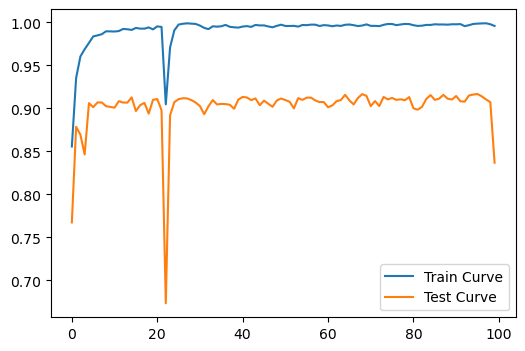

In [3]:
import pickle
import numpy as np
from matplotlib import pyplot as plt

with open("Train_Test_Data.pickle", "rb") as f:
    all_train, all_test = pickle.load(f)

plt.figure(figsize=[6, 4], dpi=100)
plt.plot(range(len(all_train)), all_train, label="Train Curve")
plt.plot(range(len(all_train)), all_test, label="Test Curve")
plt.legend()
plt.show()

### 
---

### Hyper-Tuning Version 2 Code

`train_optuna.py` code

```python
import time
import torch
import pickle
import optuna
import warnings
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from optuna.trial import TrialState
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split

warnings.filterwarnings('ignore')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# ----------------- Load CIFAR-10 Data -----------------------
    
transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
all_train = datasets.CIFAR10(root='./CIFAR_10', train=True, download=False, transform=transform)
trainset, valset = random_split(all_train, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

def stuff_data_cifar10(trial):
    batch_size = trial.suggest_categorical("batch_size", [4, 16, 64, 128, 256, 512])
    train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_dataloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    print("CIFAR-10 > Training, Testing and Validation Data Loaded Succeddfully.")
    
    return train_dataloader, val_dataloader

# ----------------- Create Model -----------------------

def get_model(trial, classes):
    model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
    model.classifier = None
    
    # all_params_count = len(list(model.parameters())) # = 211
    all_params_count = 211
    leave_layers = trial.suggest_int("leave_layers", 0, 100)
    effective_param = all_params_count - leave_layers
    
    for param in model.parameters():
        if effective_param: param.requires_grad = False
        else: break
        effective_param -= 1

    hidden_size = trial.suggest_int("hidden", 1000, 3000, 20)
    model.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d(output_size=1),
        nn.Flatten(),
        nn.Linear(in_features=1280, out_features=hidden_size),
        nn.Linear(in_features=hidden_size, out_features=classes)
    )
    
    return model

# --------------------  Training Loop  ----------------------

def accuracy(logits, labels):
    if len(logits.shape) > 1: _, indices = torch.max(logits, dim=1)
    else: indices = logits
    correct = torch.sum(indices == labels)
    return correct.item() / len(labels)


def evaluate(model, dataloader):
    model.eval()
    pred, actual = [], []
    with torch.no_grad():
        for data in dataloader:
            feat = data[0].to(device)
            label = data[1].to(device)

            logits = model(feat)
            _, out = torch.max(logits, dim=1)

            pred.append(out)
            actual.append(label)
        
    pred = torch.cat(pred)
    actual = torch.cat(actual)
    return accuracy(pred, actual)


epochs = 15
classes = 10

def training(trial):
    loss_fcn = nn.CrossEntropyLoss()
    train_dataloader, val_dataloader = stuff_data_cifar10(trial)
    model = get_model(trial, classes).to(device)
    
    # optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "NAdam", "RMSprop"])
    # optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    lr = trial.suggest_categorical("lr", [0.0125, 0.00375, 0.075, 0.115, 0.15])
    weight_decay = trial.suggest_categorical("weight_decay", [0, 4e-8, 4e-7, 4e-6, 4e-5])
    optimizer = optim.NAdam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)

    all_train, all_val = [], []
    
    for epoch in range(epochs):
        start = time.time()
        model.train()
        torch.cuda.synchronize()

        pred, actual = [], []

        for feat, labels in train_dataloader:
            feat = feat.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(feat)
            loss = loss_fcn(logits, labels)
            loss.backward()
            optimizer.step()

            _, out = torch.max(logits, dim=1)
            pred.append(out)
            actual.append(labels)

        pred = torch.cat(pred)
        actual = torch.cat(actual)

        train_acc = accuracy(pred, actual)
        val_acc = evaluate(model, val_dataloader)
        time_taken = time.time() - start
        minute, sec = list(map(int, divmod(time_taken, 60)))
        all_train.append(train_acc)
        all_val.append(val_acc)

        print(f"Epoch: {epoch + 1}/{epochs} | Train Accuracy: {train_acc:.4f} | Val Accuracy: {val_acc:.4f} | Time Taken: {minute}m {sec}s")
        # print('-' * 100)
        
        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
    return max(all_val)
        
        

if __name__ == "__main__":
    study_name = "Efficient_Transfer_Learning_V2"
    storage_name = "sqlite:///{}.db".format(study_name)
    study = optuna.create_study(study_name=study_name, storage=storage_name, direction="maximize", load_if_exists=True)
    study.optimize(training, n_trials=1000, timeout=None, n_jobs=8)
    
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    df = study.trials_dataframe()
    df.to_csv('optuna_study_V2.csv')
```

### Hyper-Tuning Version 2 Run

#### Part - I

In [ ]:
!python3 train_optuna.py

[I 2023-02-08 02:04:08,837] Using an existing study with name 'Efficient_Transfer_Learning_V2' instead of creating a new one.
CIFAR-10 > Training, Testing and Validation Data Loaded Succeddfully.
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
CIFAR-10 > Training, Testing and Validation Data Loaded Succeddfully.
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
CIFAR-10 > Training, Testing and Validation Data Loaded Succeddfully.
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
CIFAR-10 > Training, Testing and Validation Data Loaded Succeddfully.
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
CIFAR-10 > Training, Testing and Validation Data Loaded Succeddfully.
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
CIFAR-10 > Training, Testing and Validation Data Loaded Succeddfully.
Using cac

#### Part - II

In [2]:
!python3 train_optuna.py

[I 2023-02-08 21:03:29,119] Using an existing study with name 'Efficient_Transfer_Learning_V2' instead of creating a new one.
CIFAR-10 > Training, Testing and Validation Data Loaded Succeddfully.
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
CIFAR-10 > Training, Testing and Validation Data Loaded Succeddfully.
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
CIFAR-10 > Training, Testing and Validation Data Loaded Succeddfully.
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
CIFAR-10 > Training, Testing and Validation Data Loaded Succeddfully.
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
CIFAR-10 > Training, Testing and Validation Data Loaded Succeddfully.
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
CIFAR-10 > Training, Testing and Validation Data Loaded Succeddfully.
Using cac

### Hyper-Tuning Version 2 Results

In [4]:
import optuna
import pandas as pd
from optuna.trial import TrialState

study_name = "Efficient_Transfer_Learning_V2"
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.load_study(study_name=study_name, storage=storage_name)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
df = study.trials_dataframe()
df.to_csv('optuna_study_V2.csv')

Study statistics: 
  Number of finished trials:  1164
  Number of pruned trials:  932
  Number of complete trials:  208
Best trial:
  Value:  0.9169
  Params: 
    batch_size: 64
    hidden: 1180
    leave_layers: 46
    lr: 0.00375
    weight_decay: 0


In [6]:
!optuna-dashboard sqlite:///Efficient_Transfer_Learning_V2.db

Listening on http://127.0.0.1:8080/
Hit Ctrl-C to quit.

127.0.0.1 - - [10/Feb/2023 03:58:14] "GET / HTTP/1.1" 302 0
/home/anirban/anaconda3/envs/myenv/lib/python3.10/site-packages/optuna/study/_study_summary.py:121: FutureWarning: `system_attrs` has been deprecated in v3.1.0. The removal of this feature is currently scheduled for v6.0.0, but this schedule is subject to change. See https://github.com/optuna/optuna/releases/tag/v3.1.0.
  warnings.warn(
127.0.0.1 - - [10/Feb/2023 03:58:15] "GET /api/studies HTTP/1.1" 200 152
127.0.0.1 - - [10/Feb/2023 03:58:20] "GET /api/studies/1?after=0 HTTP/1.1" 200 663334
127.0.0.1 - - [10/Feb/2023 03:58:28] "GET /api/studies/1/param_importances?objective_id=0 HTTP/1.1" 200 543
^C
Traceback (most recent call last):
  File "/home/anirban/anaconda3/envs/myenv/bin/optuna-dashboard", line 8, in <module>
    sys.exit(main())
  File "/home/anirban/anaconda3/envs/myenv/lib/python3.10/site-packages/optuna_dashboard/_cli.py", line 114, in main
    run_wsgiref

### Final Training Round 2 Code

`training_cifar_10.py` code

```python
import sys
import time
import pickle
from tqdm import tqdm
import optuna
from optuna.trial import TrialState

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split
from torchvision import datasets, transforms

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# ------------------------------  Prepare CIFAR-10  Dataset   -------------------------------

transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

training_data = datasets.CIFAR10(root='./CIFAR_10', train=True, download=False, transform=transform)
testset = datasets.CIFAR10(root='./CIFAR_10', train=False, download=False, transform=transform)

trainset, valset = random_split(training_data, [0.85, 0.15], generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=4)
test_dataloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4)
classes = 10

print("CIFAR-10 > Training, Validation and Testing Data Loaded Succeddfully.")

# ------------------------------  Prepare EfficientNet Model   -------------------------------

model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
model.classifier = None

all_params_count = len(list(model.parameters()))
leave_layers = 46
effective_param = all_params_count - leave_layers

for param in model.parameters():
    if effective_param: param.requires_grad = False
    else: break
    effective_param -= 1

model.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(),
    nn.Linear(in_features=1280, out_features=1180),
    nn.Linear(in_features=1180, out_features=classes)
)

# ------------------------------------  Useful Methods  -------------------------------------

def accuracy(logits, labels):
    if len(logits.shape) > 1: _, indices = torch.max(logits, dim=1)
    else: indices = logits
    correct = torch.sum(indices == labels)
    return correct.item() / len(labels)


def evaluate(model, dataloader):
    model.eval()
    pred, actual = [], []
    with torch.no_grad():
        for data in dataloader:
            feat = data[0].to(device)
            label = data[1].to(device)

            logits = model(feat)
            _, out = torch.max(logits, dim=1)

            pred.append(out)
            actual.append(label)
            
    pred = torch.cat(pred)
    actual = torch.cat(actual)
    return accuracy(pred, actual)

# -----------------------------------   Training Loop  ----------------------------------

epochs = 1000
loss_fcn = nn.CrossEntropyLoss()
model.to(device)
optimizer = optim.NAdam(model.parameters(), lr=0.00375, betas=(0.9, 0.999), weight_decay=0)
best_val_acc, patience = 0, 10

all_train, all_val = [], []

for epoch in range(epochs):
    start = time.time()
    model.train()
    torch.cuda.synchronize()
    
    pred, actual = [], []

    # for feat, labels in tqdm(train_dataloader, ascii=" ▖▘▝▗▚▞█"):
    for feat, labels in tqdm(train_dataloader, file=sys.stdout, ascii=" >="):
        feat = feat.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(feat)
        loss = loss_fcn(logits, labels)
        loss.backward()
        optimizer.step()
        
        _, out = torch.max(logits, dim=1)

        pred.append(out)
        actual.append(labels)
        
    pred = torch.cat(pred)
    actual = torch.cat(actual)
    
    train_acc = accuracy(pred, actual)
    val_acc = evaluate(model, val_dataloader)
    time_taken = time.time() - start
    minute, sec = list(map(int, divmod(time_taken, 60)))
    all_train.append(train_acc)
    all_val.append(val_acc)
    
    if val_acc > best_val_acc:
        with open("best_model.pickle", "wb") as f:
            pickle.dump(model, f)
        patience = 0
        best_val_acc = val_acc
    else: patience += 1
    
    print(f"Epoch: {epoch + 1}/{epochs} | Train Accuracy: {train_acc:.4f} | Validation Accuracy: {val_acc:.4f} | Time Taken: {minute}m {sec}s | Patience: {patience}/10")
    print('-' * 100)
    
    if patience == 10: break



with open("best_model.pickle", "rb") as f:
    model = pickle.load(f)
    
print('=' * 100)
train_acc = evaluate(model, train_dataloader)
val_acc = evaluate(model, val_dataloader)
test_acc = evaluate(model, test_dataloader)
print(f"Train Accuracy: {train_acc:.4f} | Validation Accuracy: {val_acc:.4f} | Test Accuracy: {test_acc:.4f}")
print('=' * 100)


with open("Train_Test_Data_V2.pickle", "wb") as f:
    pickle.dump((all_train, all_val), f)

with open("Final_model_V2.pickle", "wb") as f:
    pickle.dump(model, f)
    
print("Model and Results Saved Successfully...")
```

### Training Round - 2 with parameters

- `batch_size`: 64
- `hidden`: 1180
- `leave_layers`: 46
- `lr`: 0.00375
- `weight_decay`: 0

In [1]:
import sys
import time
import pickle
from tqdm import tqdm
import optuna
from optuna.trial import TrialState

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split
from torchvision import datasets, transforms

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# ------------------------------  Prepare CIFAR-10  Dataset   -------------------------------

transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

training_data = datasets.CIFAR10(root='./CIFAR_10', train=True, download=False, transform=transform)
testset = datasets.CIFAR10(root='./CIFAR_10', train=False, download=False, transform=transform)

trainset, valset = random_split(training_data, [0.85, 0.15], generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=4)
test_dataloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4)
classes = 10

print("CIFAR-10 > Training, Validation and Testing Data Loaded Succeddfully.")

# ------------------------------  Prepare EfficientNet Model   -------------------------------

model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
model.classifier = None

all_params_count = len(list(model.parameters()))
leave_layers = 46
effective_param = all_params_count - leave_layers

for param in model.parameters():
    if effective_param: param.requires_grad = False
    else: break
    effective_param -= 1

model.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(),
    nn.Linear(in_features=1280, out_features=1180),
    nn.Linear(in_features=1180, out_features=classes)
)

# ------------------------------------  Useful Methods  -------------------------------------

def accuracy(logits, labels):
    if len(logits.shape) > 1: _, indices = torch.max(logits, dim=1)
    else: indices = logits
    correct = torch.sum(indices == labels)
    return correct.item() / len(labels)


def evaluate(model, dataloader):
    model.eval()
    pred, actual = [], []
    with torch.no_grad():
        for data in dataloader:
            feat = data[0].to(device)
            label = data[1].to(device)

            logits = model(feat)
            _, out = torch.max(logits, dim=1)

            pred.append(out)
            actual.append(label)
            
    pred = torch.cat(pred)
    actual = torch.cat(actual)
    return accuracy(pred, actual)

# -----------------------------------   Training Loop  ----------------------------------

epochs = 1000
loss_fcn = nn.CrossEntropyLoss()
model.to(device)
optimizer = optim.NAdam(model.parameters(), lr=0.00375, betas=(0.9, 0.999), weight_decay=0)
best_val_acc, patience = 0, 10

all_train, all_val = [], []

for epoch in range(epochs):
    start = time.time()
    model.train()
    torch.cuda.synchronize()
    
    pred, actual = [], []

    # for feat, labels in tqdm(train_dataloader, ascii=" ▖▘▝▗▚▞█"):
    for feat, labels in tqdm(train_dataloader, file=sys.stdout, ascii=" >="):
        feat = feat.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(feat)
        loss = loss_fcn(logits, labels)
        loss.backward()
        optimizer.step()
        
        _, out = torch.max(logits, dim=1)

        pred.append(out)
        actual.append(labels)
        
    pred = torch.cat(pred)
    actual = torch.cat(actual)
    
    train_acc = accuracy(pred, actual)
    val_acc = evaluate(model, val_dataloader)
    time_taken = time.time() - start
    minute, sec = list(map(int, divmod(time_taken, 60)))
    all_train.append(train_acc)
    all_val.append(val_acc)
    
    if val_acc > best_val_acc:
        with open("best_model.pickle", "wb") as f: pickle.dump(model, f)
        patience = 0
        best_val_acc = val_acc
    else: patience += 1
    
    print(f"Epoch: {epoch + 1}/{epochs} | Train Accuracy: {train_acc:.4f} | Validation Accuracy: {val_acc:.4f} | Time Taken: {minute}m {sec}s | Patience: {patience}/10")
    print('-' * 100)
    
    if patience == 10: break


print('=' * 100)
with open("best_model.pickle", "rb") as f: model = pickle.load(f)
train_acc = evaluate(model, train_dataloader)
val_acc = evaluate(model, val_dataloader)
test_acc = evaluate(model, test_dataloader)
print(f"Train Accuracy: {train_acc:.4f} | Validation Accuracy: {val_acc:.4f} | Test Accuracy: {test_acc:.4f}")
print('=' * 100)

with open("Train_Test_Data_V2.pickle", "wb") as f: pickle.dump((all_train, all_val), f)
with open("Final_model_V2.pickle", "wb") as f: pickle.dump(model, f)
    
print("Model and Results Saved Successfully...")

CIFAR-10 > Training, Validation and Testing Data Loaded Succeddfully.


Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


100%|==============================================================================================================================================| 665/665 [00:31<00:00, 21.13it/s]
Epoch: 1/1000 | Train Accuracy: 0.8262 | Validation Accuracy: 0.8403 | Time Taken: 0m 35s | Patience: 0/10
----------------------------------------------------------------------------------------------------
100%|==============================================================================================================================================| 665/665 [00:30<00:00, 21.51it/s]
Epoch: 2/1000 | Train Accuracy: 0.9075 | Validation Accuracy: 0.7412 | Time Taken: 0m 34s | Patience: 1/10
----------------------------------------------------------------------------------------------------
100%|==============================================================================================================================================| 665/665 [00:31<00:00, 21.36it/s]
Epoch: 3/1000 | Train Accuracy: 0.9333

### Result of Round - 2

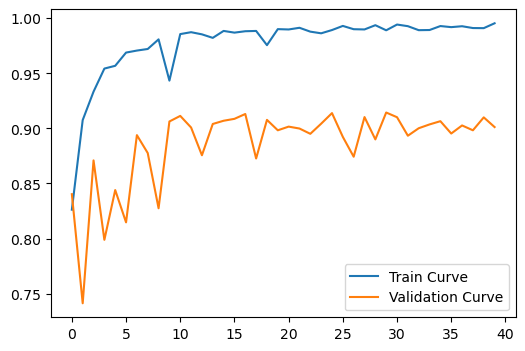

In [2]:
import pickle
import numpy as np
from matplotlib import pyplot as plt

with open("Train_Test_Data_V2.pickle", "rb") as f: all_train, all_val = pickle.load(f)

plt.figure(figsize=[6, 4], dpi=100)
plt.plot(range(len(all_train)), all_train, label="Train Curve")
plt.plot(range(len(all_train)), all_val, label="Validation Curve")
plt.legend()
plt.show()

### Extract and Save Embeddings

In [3]:
# Add hook to model
def embedding_hook(layer, inp, out):
    embeddings.append(out.detach().cpu())

model.classifier[2].register_forward_hook(embedding_hook)

In [4]:
model.eval()

embeddings = []
labels = []

for feat, label in tqdm(train_dataloader, file=sys.stdout, ascii=" ▖▘▝▗▚▞█"):
    feat = feat.to(device)
    logits = model(feat)
    labels.append(label)

for feat, label in tqdm(val_dataloader, file=sys.stdout, ascii=" ▖▘▝▗▚▞█"):
    feat = feat.to(device)
    logits = model(feat)
    labels.append(label)
    
for feat, label in tqdm(test_dataloader, file=sys.stdout, ascii=" ▖▘▝▗▚▞█"):
    feat = feat.to(device)
    logits = model(feat)
    labels.append(label)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.34it/s]


In [5]:
all_embeddings = torch.cat(embeddings)
all_labels = torch.cat(labels)

with open("EfficientNet_CIFAR_10_Embeddings.pickle", "wb") as f:
    pickle.dump({"embeddings" : all_embeddings, "labels" : all_labels}, f)